In [1]:
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from dqn_agent import DQNAgent
from utils import make_epsilon_greedy_policy
from PIL import Image

In [2]:
# Choose your environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)



In [3]:
# Hyperparameters, Hint: Change as you see fit
LR = 0.0005
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 10_000_00
UPDATE_FREQ = 500
EPS_START = 1.0
EPS_END = 0.1
SCHEDULE_DURATION = 25_000
NUM_EPISODES = 30_000
DISCOUNT_FACTOR = 0.98
N_STEPS = 5

Episode 100 of 30000  Time Step: 1014  Epsilon: 0.964
Episode 200 of 30000  Time Step: 2090  Epsilon: 0.925
Episode 300 of 30000  Time Step: 3232  Epsilon: 0.884
Episode 400 of 30000  Time Step: 4382  Epsilon: 0.842
Episode 500 of 30000  Time Step: 5638  Epsilon: 0.797
Episode 600 of 30000  Time Step: 6936  Epsilon: 0.750
Episode 700 of 30000  Time Step: 8476  Epsilon: 0.695
Episode 800 of 30000  Time Step: 9928  Epsilon: 0.643
Episode 900 of 30000  Time Step: 11400  Epsilon: 0.590
Episode 1000 of 30000  Time Step: 13346  Epsilon: 0.520
Episode 1100 of 30000  Time Step: 15292  Epsilon: 0.450
Episode 1200 of 30000  Time Step: 17698  Epsilon: 0.363
Episode 1300 of 30000  Time Step: 20286  Epsilon: 0.270
Episode 1400 of 30000  Time Step: 23496  Epsilon: 0.154
Episode 1500 of 30000  Time Step: 27554  Epsilon: 0.100
Episode 1600 of 30000  Time Step: 31890  Epsilon: 0.100
Episode 1700 of 30000  Time Step: 36192  Epsilon: 0.100
Episode 1800 of 30000  Time Step: 40816  Epsilon: 0.100
Episode 1

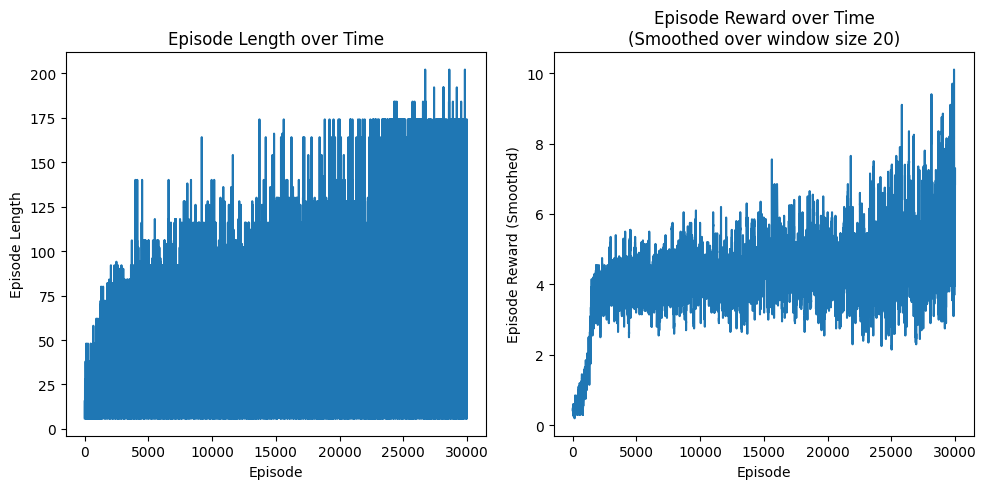

In [4]:
# Train DQN
agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES, N_STEPS)


smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

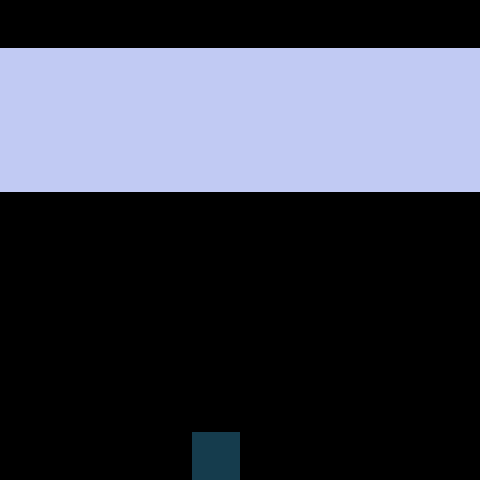

In [6]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")